This notebook creates a basic Convolutioin Neural Net using Flux to predict estimated force needed by the exoskeleton. \\

Input data is file "f1_processed_data.csv". Saves model as "CNN-model.bson", train loss, and test loss \\

The model uses as it's training data strides from the time of the end of the last plantar flexion to about 150 ms before the start of the next plantar flexion. At this point, the model predicts a "relative force". The relative force is defined as the acceleration_z^2 + acceleration_x^2 (where x points forward, z points up, and y points side to side). Mass is assumed to be constant and is not included. 

In [1]:
using Pkg

In [2]:
using Flux
using Flux: onehot, chunk, batchseq, throttle, crossentropy
using StatsBase: wsample
using Base.Iterators: partition
using CSV
using MultivariateStats
using LinearAlgebra
using StatsBase
using Random
using BSON: @save
using Dates
using Plots
using Statistics

loaded


In [3]:
BIN_STEP = .0001;
N_FEATURES = 6;
ALPHABET_SIZE = 200;

In [4]:
add_dim(x::Array,dim) = reshape(x, (size(x)...,1))

add_dim (generic function with 1 method)

In [5]:
prctile(x::Array,p) = sort(x)[Int(round((p/100)*length(x)))]

prctile (generic function with 1 method)

In [6]:
# Process data, defining start and end PF times as relative points within the stride cycle. Heel strikes have been found
# and marked in a previous file

text = CSV.read("f1_processed_data.csv", header=0);
text = convert(Array, text);
timepts = text[:,1];
heel_strike = findall(text[:,8].==1);


cycle_time = heel_strike[2:end] .- heel_strike[1:end-1];
startPF = Int.(round.(heel_strike[1:end-1] .+ .3 .*cycle_time .- 15));
PFend = Int.(round.(heel_strike[1:end-1] .+ .6 .*cycle_time));

labels = text[:,end];
data_unNorm = text[:,[2,3,4,5,6,7]];

means = [mean(data_unNorm[:,col]) for col in range(1,size(data_unNorm,2))];
std_data = [std(data_unNorm[:,col]) for col in range(1,size(data_unNorm,2))];
means = reshape(means,(1,6));
data0 = data_unNorm .-means;
data0 = data0 ./ reshape(std_data, (1,6));

In [7]:
PF_idxs = [collect(s:e) for (s, e) in zip(startPF, PFend)];
PF_idxs = PF_idxs[2:end]
training_idxs = [collect(s:e) for (s, e) in zip(PFend[1:end-1], startPF[2:end])];

In [8]:
max_forces_tst = [];
max_forces_tr = [];
tr_data_stride = [];
tst_data_stride = [];
seqlens = [];
sfl = shuffle(1:length(PF_idxs)-1)
for s in sfl
    force = sqrt.(data0[PF_idxs[s],1].^2 .+ data0[PF_idxs[s],3].^2)
    data_add = data0[training_idxs[s],:]
    append!(seqlens, size(data_add)[1])
    if s > round(.8*(length(PF_idxs)-1))
        append!(tst_data_stride, [data_add])
        append!(max_forces_tst, maximum(force))
    else
        append!(tr_data_stride, [data_add])
        append!(max_forces_tr, maximum(force))
    end
end

In [9]:
length(sfl)
length(tst_data_stride)
length(tr_data_stride)

446

In [10]:
size(tr_data_stride[1])

(56, 6)

In [11]:
function custom_pad(data, seqlen, pad)
    dnew = [];
    for dat in data
        if size(dat)[1]<seqlen
            dat = vcat(dat, fill(pad,(seqlen-size(dat)[1], N_FEATURES)));            
        end
        datn = dat[1:seqlen,:]
        
        append!(dnew, [datn])
    end
    return dnew
end

custom_pad (generic function with 1 method)

In [12]:
seqlen = prctile(seqlens, 75);
tst_data_stride = custom_pad(tst_data_stride, seqlen, 0);
tr_data_stride = custom_pad(tr_data_stride, seqlen, 0);

In [13]:
partitions = [i:i+9 for i in 1:10:length(tr_data_stride)-9];
train = [(cat(float.(tr_data_stride[i])..., dims = 4), max_forces_tr[i])
         for i in partitions];

In [14]:
size(tr_data_stride[1])

(113, 6)

In [15]:
using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Flux: @epochs
# using CuArrays

# # Classify MNIST digits with a convolutional network

# imgs = MNIST.images()

# labels = onehotbatch(MNIST.labels(), 0:9)

# # Partition into batches of size 1,000
partitions = [i:i+9 for i in 1:10:length(tr_data_stride)-9];
train = [(cat(float.(tr_data_stride[i])..., dims = 4), max_forces_tr[i])
         for i in partitions];
# println(typeof(max_forces_tr))
# train = convert.(Array{Float32,2}, tr_data_stride);
train = gpu.(train) |> gpu
# labels = gpu.(Float32.(max_forces_tr))

# train = [(cat(float.(train[i])..., dims = 4), labels[i])
#          for i in length(train)]
# println(length(train))

m = Chain(
  Conv((2,2), 1=>16, relu),
  x -> maxpool(x, (2,2)),
  Conv((2,2), 16=>8, relu),
  x -> maxpool(x, (2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(216, 1)) |> gpu

function mse_loss(x,y)
    y_hat = m(x);
    y_hat = reshape(y_hat, length(y_hat));

    return sqrt(sum(y_hat .- y).^2)/length(y)
end

tY = gpu.(Float32.(max_forces_tst[1]))
tX = reshape(float.(tst_data_stride[1]), (size(tst_data_stride[1],1),size(tst_data_stride[1],2),1,1)) |> gpu

tYr = gpu.(Float32.(max_forces_tr[1]))
tXr = reshape(float.(tr_data_stride[1]), (size(tr_data_stride[1],1),size(tr_data_stride[1],2),1,1)) |> gpu

# tst_acc = cat(float.(tst_data_stride)..., dims = 4);

opt = ADAM(params(m))
loss_vec= [];
test_loss_vec = [];
evalcb = throttle(1) do
    @show "Train Loss" mse_loss(tXr, tYr)
    @show "Test Loss" mse_loss(tX, tY)
    append!(loss_vec, mse_loss(tXr, tYr).data)
    append!(test_loss_vec, mse_loss(tX, tY).data)
end

# Flux.train!(mseloss, train, opt, cb = evalcb)
@epochs 450 Flux.train!(mse_loss, train, opt, cb = evalcb)
@save "CNN-model_latest.bson" m opt

┌ Info: Epoch 1
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 2.3610985111173988 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.4035662865664245 (tracked)


┌ Info: Epoch 2
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 3
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6388543302083489 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6810150654360587 (tracked)


┌ Info: Epoch 4
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 5
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 6
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.1309532305696579 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.3103171801924733 (tracked)


┌ Info: Epoch 7
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 8
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3444660980108125 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.0520871726423167 (tracked)


┌ Info: Epoch 9
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 10
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.08709168313830062 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.3863584277654684 (tracked)


┌ Info: Epoch 11
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 12
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 13
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5534060315653733 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.7955528192691954 (tracked)


┌ Info: Epoch 14
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 15
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 16
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.09135720116355639 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.372405602016162 (tracked)


┌ Info: Epoch 17
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 18
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.621419381335071 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.7096309309883488 (tracked)


┌ Info: Epoch 19
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 20
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 21
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6414147667123165 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.675406578481772 (tracked)


┌ Info: Epoch 22
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 23
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 24
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5121190824771957 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.796670004332011 (tracked)


┌ Info: Epoch 25
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 26
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 27
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.23805057514263916 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.1400740944147603 (tracked)


┌ Info: Epoch 28
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 29
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 30
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.0993338684263465 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.2866381364313528 (tracked)


┌ Info: Epoch 31
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 32
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.39865334544588094 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.9109955151840277 (tracked)


┌ Info: Epoch 33
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 34
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 35
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5389071425219636 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.7443876195097299 (tracked)


┌ Info: Epoch 36
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 37
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.411832586404824 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.8781371465284074 (tracked)


┌ Info: Epoch 38
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 39
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 40
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5867686920213713 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6658135549742763 (tracked)


┌ Info: Epoch 41
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 42
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 43
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.49394950480352184 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.7597675627144391 (tracked)


┌ Info: Epoch 44
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 45
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.15538257757228857 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.1793467056983729 (tracked)


┌ Info: Epoch 46
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 47
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 48
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5471596303833304 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6768310134738309 (tracked)


┌ Info: Epoch 49
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 50
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.48862743854598145 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.7441954303148317 (tracked)


┌ Info: Epoch 51
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 52
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 53
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5731054554552037 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6437134866042133 (tracked)


┌ Info: Epoch 54
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 55
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 56
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.11409288673053286 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 1.1824524635085578 (tracked)


┌ Info: Epoch 57
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 58
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5613162619265104 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6521757026174368 (tracked)


┌ Info: Epoch 59
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 60
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 61
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.582971901197807 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6290392706078083 (tracked)


┌ Info: Epoch 62
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 63
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.41782696733935576 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.799149845912658 (tracked)


┌ Info: Epoch 64
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 65
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 66
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.28109373496441314 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.9414626887425279 (tracked)


┌ Info: Epoch 67
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 68
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5685172398325882 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5771249824722018 (tracked)


┌ Info: Epoch 69
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 70
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 71
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5194467295424066 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6141356151605177 (tracked)


┌ Info: Epoch 72
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 73
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.24581122346601303 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.9460096635132111 (tracked)


┌ Info: Epoch 74
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 75
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 76
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5689393629830837 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5359749656205453 (tracked)


┌ Info: Epoch 77
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 78
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 79
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4208325653003908 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6641366744418686 (tracked)


┌ Info: Epoch 80
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 81
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 82
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.19432391125912485 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.8847705677079083 (tracked)


┌ Info: Epoch 83
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 84
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5082409651887732 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4659600583373775 (tracked)


┌ Info: Epoch 85
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5428390522390685 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4851882103617915 (tracked)


┌ Info: Epoch 86
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 87
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.25122840524460077 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.7977450772438184 (tracked)


┌ Info: Epoch 88
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 89
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6324238646543059 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3816481377204193 (tracked)


┌ Info: Epoch 90
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 91
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4738215173511642 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5543111378075292 (tracked)


┌ Info: Epoch 92
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 93
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 94
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7224239110772328 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2542616691942319 (tracked)


┌ Info: Epoch 95
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 96
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 97
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.43619052903809363 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5761538547517893 (tracked)


┌ Info: Epoch 98
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 99
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 100
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.436050904144369 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5231997110382116 (tracked)


┌ Info: Epoch 101
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 102
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7558664999478486 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.18116002806701825 (tracked)


┌ Info: Epoch 103
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 104
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 105
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6193965208419103 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3186144524801009 (tracked)


┌ Info: Epoch 106
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 107
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 108
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3835675591445262 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5659067668844853 (tracked)


┌ Info: Epoch 109
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 110
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.570234854831801 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.35168949315311826 (tracked)


┌ Info: Epoch 111
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 112
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.42593335973396407 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.47549967147126915 (tracked)


┌ Info: Epoch 113
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 114
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4017398663169507 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.45162417783132813 (tracked)


┌ Info: Epoch 115
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 116
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6935465708080788 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.12714513840043584 (tracked)


┌ Info: Epoch 117
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 118
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 119
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3086826538107319 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5185198416156558 (tracked)


┌ Info: Epoch 120
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 121
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3024267579460278 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.555300638562529 (tracked)


┌ Info: Epoch 122
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7618256688926195 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.0648836287298884 (tracked)


┌ Info: Epoch 123
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 124
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.49211550452825303 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2931365528241463 (tracked)


┌ Info: Epoch 125
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 126
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6157397908537376 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.18283567590299965 (tracked)


┌ Info: Epoch 127
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 128
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 129
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.33067183387686105 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5062582792101673 (tracked)


┌ Info: Epoch 130
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.734022629402886 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.11335518227781827 (tracked)


┌ Info: Epoch 131
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 132
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6829427629768865 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.17659919250172207 (tracked)


┌ Info: Epoch 133
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 134
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.49713459990403397 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.23009401375643646 (tracked)


┌ Info: Epoch 135
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 136
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4928932949749645 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.22928504209680867 (tracked)


┌ Info: Epoch 137
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 138
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5733226387267196 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.19090013089281266 (tracked)


┌ Info: Epoch 139
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 140
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.37359149858073804 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4384192404458629 (tracked)


┌ Info: Epoch 141
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 142
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.19918037015031098 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5680232734014057 (tracked)


┌ Info: Epoch 143
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.19414842002611898 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5970878216096662 (tracked)


┌ Info: Epoch 144
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 145
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.17813696258977618 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5967712062692327 (tracked)


┌ Info: Epoch 146
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 147
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.39182442732695955 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.22312888376149842 (tracked)


┌ Info: Epoch 148
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 149
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.44808979274635763 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.27822115383152757 (tracked)


┌ Info: Epoch 150
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.21786223241476987 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.42742680637376296 (tracked)


┌ Info: Epoch 151
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.455478995101245 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.09741250543176116 (tracked)


┌ Info: Epoch 152
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 153
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.24046290842547347 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.22693965526204884 (tracked)


┌ Info: Epoch 154
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 155
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.06422600141775092 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.42493192793721235 (tracked)


┌ Info: Epoch 156
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 157
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.10127743771882924 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6041446423200889 (tracked)


┌ Info: Epoch 158
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 159
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6210583419776028 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.1731325098961558 (tracked)


┌ Info: Epoch 160
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 161
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 162
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7087386073444986 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.22392139176835446 (tracked)


┌ Info: Epoch 163
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.41077915556745026 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.19951046627024804 (tracked)


┌ Info: Epoch 164
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 165
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.014130857806508246 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.734531699003492 (tracked)


┌ Info: Epoch 166
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7454077895892495 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.08569485758214768 (tracked)


┌ Info: Epoch 167
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 168
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 169
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5090795127881611 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2959388688017208 (tracked)


┌ Info: Epoch 170
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5508784059546741 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.24911862344195024 (tracked)


┌ Info: Epoch 171
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 172
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.02600033268553492 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.7583964157762897 (tracked)


┌ Info: Epoch 173
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 174
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7707325055909495 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.08627750550837177 (tracked)


┌ Info: Epoch 175
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5157449205198921 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.38684000709636956 (tracked)


┌ Info: Epoch 176
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 177
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.654230609806443 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.26698304276403784 (tracked)


┌ Info: Epoch 178
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.136314026660731 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.8466609903398759 (tracked)


┌ Info: Epoch 179
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 180
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6603142711471321 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3531390037327107 (tracked)


┌ Info: Epoch 181
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7040562789118714 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.31022151272739906 (tracked)


┌ Info: Epoch 182
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 183
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6311532528225294 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.30017511479066816 (tracked)


┌ Info: Epoch 184
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.48404127861373913 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4699219787313689 (tracked)


┌ Info: Epoch 185
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5905094039084142 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.34265098672297056 (tracked)


┌ Info: Epoch 186
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 187
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.22999935090699264 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6779200495116289 (tracked)


┌ Info: Epoch 188
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 189
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3244190036965384 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5393905615065755 (tracked)


┌ Info: Epoch 190
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3768964564835824 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5038846582103775 (tracked)


┌ Info: Epoch 191
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 192
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.37605167791480154 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.40215021762749004 (tracked)


┌ Info: Epoch 193
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 194
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.30036746664131364 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.48709705009376236 (tracked)


┌ Info: Epoch 195
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.41793495499850386 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.309364057780954 (tracked)


┌ Info: Epoch 196
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 197
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.13159083776445435 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5262210011970576 (tracked)


┌ Info: Epoch 198
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 199
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5807270741837842 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2183989619383253 (tracked)


┌ Info: Epoch 200
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.24571073857939707 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5460217684994284 (tracked)


┌ Info: Epoch 201
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 202
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5123965754384163 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.16469338312145565 (tracked)


┌ Info: Epoch 203
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.19785870655941995 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.43995859353464883 (tracked)


┌ Info: Epoch 204
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4325101412419068 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.20736236863351865 (tracked)


┌ Info: Epoch 205
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 206
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4832330328705283 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.18371275576259816 (tracked)


┌ Info: Epoch 207
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.47411082382517655 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.12296111771782026 (tracked)


┌ Info: Epoch 208
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 209
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.21598789655252126 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.28545647270984276 (tracked)


┌ Info: Epoch 210
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 211
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.21682810549871467 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.26631056980607415 (tracked)


┌ Info: Epoch 212
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.26933797321069886 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2746311144846789 (tracked)


┌ Info: Epoch 213
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.2241523809671344 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2709790525044604 (tracked)


┌ Info: Epoch 214
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 215
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.16506137104494067 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3034114396692176 (tracked)


┌ Info: Epoch 216
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 217
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.27966154053295655 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.183091588719007 (tracked)


┌ Info: Epoch 218
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 219
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3781494723535368 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.08776704006940705 (tracked)


┌ Info: Epoch 220
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 221
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4159355628443797 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.011432257312690819 (tracked)


┌ Info: Epoch 222
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 223
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.34393087656282617 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.04876117877723973 (tracked)


┌ Info: Epoch 224
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 225
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 226
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4696153537516419 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.03327711105169895 (tracked)


┌ Info: Epoch 227
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 228
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.337430246204502 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.08574959192479148 (tracked)


┌ Info: Epoch 229
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 230
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.23088419013259598 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.10703141979065389 (tracked)


┌ Info: Epoch 231
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 232
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3691449155447841 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.052417397163679214 (tracked)


┌ Info: Epoch 233
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.29560420672335175 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.08007302446744125 (tracked)


┌ Info: Epoch 234
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 235
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.23386663383136685 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.022823088380689915 (tracked)


┌ Info: Epoch 236
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 237
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.1402880170903864 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.14594324138403048 (tracked)


┌ Info: Epoch 238
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.1634637490798152 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.16956456495298533 (tracked)


┌ Info: Epoch 239
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 240
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4664154105022491 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.09903722057646558 (tracked)


┌ Info: Epoch 241
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 242
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5434693533441197 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.20009100679342784 (tracked)


┌ Info: Epoch 243
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.06982564705176353 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.17369311560647938 (tracked)


┌ Info: Epoch 244
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 245
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.36295531868046105 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.042282141363241266 (tracked)


┌ Info: Epoch 246
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 247
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4460530351389578 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.061856053577902026 (tracked)
"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.36572296126766046 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.012689883030990723 (tracked)


┌ Info: Epoch 248
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 249
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5401969465807057 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.19529171944569246 (tracked)


┌ Info: Epoch 250
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 251
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.45995368130069925 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.12783307988097148 (tracked)


┌ Info: Epoch 252
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 253
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.32705009009645236 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.014497645777411972 (tracked)


┌ Info: Epoch 254
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 255
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.17223500049321583 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.17112576954591274 (tracked)


┌ Info: Epoch 256
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 257
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.16876662442289447 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.1931225229968072 (tracked)


┌ Info: Epoch 258
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 259
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.28034911896420356 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.09966758345568305 (tracked)


┌ Info: Epoch 260
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 261
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 262
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4834748177761423 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.12364531080950147 (tracked)


┌ Info: Epoch 263
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 264
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5065852410546816 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.07931866082288352 (tracked)


┌ Info: Epoch 265
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 266
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3948020342915992 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.030365686574276518 (tracked)


┌ Info: Epoch 267
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 268
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4731998414485541 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.046628801732369274 (tracked)


┌ Info: Epoch 269
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 270
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.13027054134548388 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2746154649470154 (tracked)


┌ Info: Epoch 271
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5569027792910808 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.03810509450124866 (tracked)


┌ Info: Epoch 272
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 273
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.37589800478551005 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.248457929101912 (tracked)


┌ Info: Epoch 274
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 275
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.34055129839281184 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.34044519436421194 (tracked)


┌ Info: Epoch 276
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 277
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.17902092313141704 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.395469467979394 (tracked)


┌ Info: Epoch 278
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 279
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 280
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.1451024505467604 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.42112501246395007 (tracked)


┌ Info: Epoch 281
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 282
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.32000307259977223 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3093021651182739 (tracked)


┌ Info: Epoch 283
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 284
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.48097152305529933 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.1568384846788986 (tracked)


┌ Info: Epoch 285
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 286
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4263811586381179 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2041214298045395 (tracked)


┌ Info: Epoch 287
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 288
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3614772847630219 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.29885013853359954 (tracked)


┌ Info: Epoch 289
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 290
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5121137693888085 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 

┌ Info: Epoch 291
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


0.20069400362134737 (tracked)


┌ Info: Epoch 292
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 293
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.17255672952075285 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4634663013542919 (tracked)


┌ Info: Epoch 294
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 295
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3224263960467004 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.38087012054389735 (tracked)


┌ Info: Epoch 296
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 297
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.4821455792518248 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2719730621660874 (tracked)


┌ Info: Epoch 298
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 299
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5980761748114776 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.15972332559727231 (tracked)


┌ Info: Epoch 300
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 301
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6752096096409956 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.09533988667388615 (tracked)


┌ Info: Epoch 302
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 303
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6812307449941597 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.11103233145697211 (tracked)


┌ Info: Epoch 304
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 305
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.514961165365174 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.19818647867655725 (tracked)


┌ Info: Epoch 306
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 307
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.48729123812499076 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.22698525793186874 (tracked)


┌ Info: Epoch 308
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 309
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 310
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.49660537133545635 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.27064556348367796 (tracked)


┌ Info: Epoch 311
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 312
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.38191639209844586 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.16795454547270738 (tracked)


┌ Info: Epoch 313
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 314
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.546350012296035 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.1906675779429412 (tracked)


┌ Info: Epoch 315
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 316
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5074741912951302 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.1885492209572186 (tracked)


┌ Info: Epoch 317
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 318
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7052061537877103 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.029564334116052304 (tracked)


┌ Info: Epoch 319
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 320
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.712150121726459 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.01981214471294357 (tracked)


┌ Info: Epoch 321
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 322
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7066736065811745 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.004530783320989329 (tracked)


┌ Info: Epoch 323
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 324
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6800193387309255 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.09415862504454542 (tracked)


┌ Info: Epoch 325
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 326
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.774325340133226 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.006724637264880595 (tracked)


┌ Info: Epoch 327
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 328
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 329
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6514902278341559 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.07537252208942125 (tracked)


┌ Info: Epoch 330
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 331
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6003792528102561 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.1611698049212853 (tracked)


┌ Info: Epoch 332
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 333
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.46505897387835904 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2690047193258265 (tracked)


┌ Info: Epoch 334
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 335
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6033832445086604 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2909372522473639 (tracked)


┌ Info: Epoch 336
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 337
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6278969663949754 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.260207094037463 (tracked)


┌ Info: Epoch 338
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 339
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5850340340533964 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.29534918948252264 (tracked)


┌ Info: Epoch 340
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 341
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7354210317016658 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.03653403057774263 (tracked)


┌ Info: Epoch 342
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 343
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.9456588101941203 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.1753007015762471 (tracked)


┌ Info: Epoch 344
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 345
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.9506320204758627 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.04120088988039328 (tracked)


┌ Info: Epoch 346
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 347
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.9904795154268984 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2015468900008337 (tracked)


┌ Info: Epoch 348
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 349
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 350
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 1.0532911717846638 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.24118704041570171 (tracked)


┌ Info: Epoch 351
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 352
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 1.0005588642173384 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.2901735550647331 (tracked)


┌ Info: Epoch 353
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 354
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.9270886959609699 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4049177193329607 (tracked)


┌ Info: Epoch 355
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 356
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7026649399428844 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5395692839898634 (tracked)


┌ Info: Epoch 357
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 358
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3938933450495474 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.717274353238051 (tracked)


┌ Info: Epoch 359
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 360
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3856046201541721 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.699351631173279 (tracked)


┌ Info: Epoch 361
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 362
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3346381203158284 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6882414512427775 (tracked)


┌ Info: Epoch 363
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 364
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3197879128793799 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.653473838216514 (tracked)


┌ Info: Epoch 365
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 366
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.2845129356983138 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6278223867091861 (tracked)


┌ Info: Epoch 367
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 368
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 369
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.2659233444968314 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5859069039642482 (tracked)


┌ Info: Epoch 370
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 371
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3811079428708022 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.46855072636001704 (tracked)


┌ Info: Epoch 372
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 373
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.37102540337171575 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.451989970802795 (tracked)


┌ Info: Epoch 374
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 375
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.43808974646292675 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3674824099974292 (tracked)


┌ Info: Epoch 376
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 377
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.37101923914787305 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.35590206330755025 (tracked)


┌ Info: Epoch 378
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 379
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.2561466081337862 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.46479870009302227 (tracked)


┌ Info: Epoch 380
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 381
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.26419572966425875 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.48231735089218586 (tracked)


┌ Info: Epoch 382
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 383
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.30058652717155265 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4997054798650946 (tracked)


┌ Info: Epoch 384
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 385
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.21567349384063128 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5519410205012902 (tracked)


┌ Info: Epoch 386
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 387
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 388
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.13065367238339398 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5872703282531702 (tracked)


┌ Info: Epoch 389
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 390
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.19011405546916293 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.45052402323484353 (tracked)


┌ Info: Epoch 391
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 392
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.1042898180154177 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5322365446441168 (tracked)


┌ Info: Epoch 393
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 394
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.35467070717424365 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3392880545441357 (tracked)


┌ Info: Epoch 395
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 396
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.535000330159686 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.19294728532317218 (tracked)


┌ Info: Epoch 397
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 398
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6531030117979104 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.10418634684928563 (tracked)


┌ Info: Epoch 399
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 400
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6634466508244192 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.0774144867225095 (tracked)


┌ Info: Epoch 401
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 402
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6244300209019298 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.16038461956316774 (tracked)


┌ Info: Epoch 403
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 404
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 

┌ Info: Epoch 405
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


0.62949321508236 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.15705524556451467 (tracked)


┌ Info: Epoch 406
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 407
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6085178042085686 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.21114048639313987 (tracked)


┌ Info: Epoch 408
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 409
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6400867408187922 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.19186013660724432 (tracked)


┌ Info: Epoch 410
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 411
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5515320665253411 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3377788573879892 (tracked)


┌ Info: Epoch 412
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 413
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.7727503099348847 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.4955160325327017 (tracked)


┌ Info: Epoch 414
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 415
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.6299119618001565 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6108312695651508 (tracked)


┌ Info: Epoch 416
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 417
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 418
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.38272522209643767 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6608412293530144 (tracked)


┌ Info: Epoch 419
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 420
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 421
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.28808592193636384 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6579365446205605 (tracked)


┌ Info: Epoch 422
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 423
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 424
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.2161457994870668 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6073880381806345 (tracked)


┌ Info: Epoch 425
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 426
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 427
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.412183991102373 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.3703185707204504 (tracked)


┌ Info: Epoch 428
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 429
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 430
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.37948916354191375 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.41668347271390793 (tracked)


┌ Info: Epoch 431
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 432
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 433
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3437678078695656 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5416365024595997 (tracked)


┌ Info: Epoch 434
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 435
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 436
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.09875519009863964 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.6128714784945708 (tracked)


┌ Info: Epoch 437
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 438
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 439
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.08883463087037757 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5461984865481053 (tracked)


┌ Info: Epoch 440
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 441
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 442
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.15787144801323727 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.5245935733155578 (tracked)


┌ Info: Epoch 443
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 444
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 445
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.3801664652503005 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.39452585539114793 (tracked)


┌ Info: Epoch 446
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 447
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 448
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


"Train Loss" = "Train Loss"
mse_loss(tXr, tYr) = 0.5317279052094332 (tracked)
"Test Loss" = "Test Loss"
mse_loss(tX, tY) = 0.38866971174373743 (tracked)


┌ Info: Epoch 449
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 450
└ @ Main /Users/jenniferdawkins/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


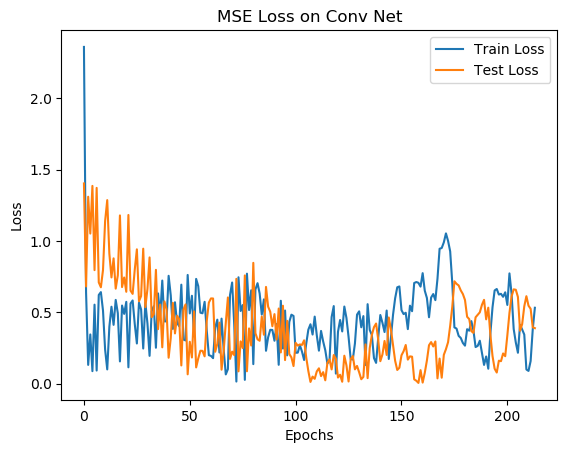

PyObject <matplotlib.legend.Legend object at 0x13d2855c0>

In [17]:
# loss_vec = [l.data for l in loss_vec]
using PyPlot
PyPlot.plot(loss_vec, label = "Train Loss")
PyPlot.plot(test_loss_vec, label= "Test Loss")
xlabel("Epochs")
ylabel("Loss")
title("MSE Loss on Conv Net")
legend(loc="upper right",fancybox="true")

In [22]:
write("convNet_testloss_latest.csv", DataFrame(reshape(test_loss_vec,1,length(test_loss_vec))))
write("convNet_loss_latest.csv", DataFrame(reshape(loss_vec,1,length(loss_vec))))

UndefVarError: UndefVarError: DataFrame not defined

In [341]:
println(backend())

Plots.GRBackend()


In [370]:
using Plots
Plots.plotlyjs()
x = 0:2*pi:100 |> collect 
dt, nsteps = 0.03, 3
for n = 1:nsteps
    IJulia.clear_output(true)
    Plots.plot(x[n], sin(x - n*dt))  |> display
end

MethodError: MethodError: no method matching -(::Array{Float64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:397
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:298
  -(!Matched::Missing, ::Number) at missing.jl:93
  ...

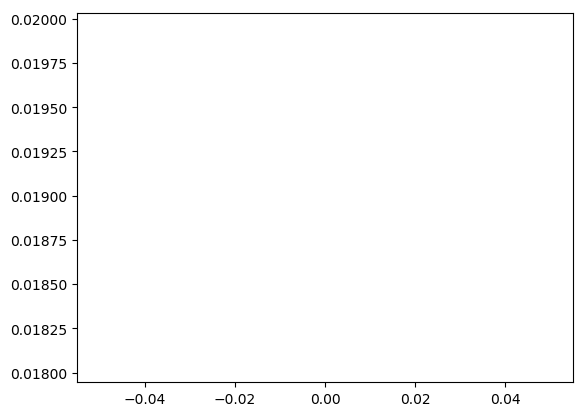

┌ Info: Saved animation to 
│   fn = /Users/jenniferdawkins/exoRL/tmp.gif
└ @ Plots /Users/jenniferdawkins/.julia/packages/Plots/rmogG/src/animation.jl:90


Plots.AnimatedGif("/Users/jenniferdawkins/exoRL/tmp.gif")

In [39]:
sample_vec = shuffle(1:length(tst_data_stride))
i = sample_vec[1];
input_data = reshape(float.(tst_data_stride[i]), (size(tst_data_stride[i],1),size(tst_data_stride[i],2),1,1));
guess = m(input_data).data;
truth = max_forces_tst[i];
guess = 
timevec = collect(0:10:size(input_data,1)*10);

PyPlot.plot([timevec[1]], [tst_data_stride[i][1,1]])
@gif for j=2:length(timevec)-1
    plot!([timevec[j]], [tst_data_stride[i][j,1]], label = "")
    if j == length(timevec)-1
        bar!([timevec[j]], [truth], label="True Force")
        bar!([timevec[j]], [guess], label="Guess")
    end
end every 10

In [90]:
@save "ConvVars.jld2" tst_data_stride input_data max_forces_tst 

In [92]:
# save workspace
# @save "$(now())-ConvVars.jld" tst_data_stride input_data max_forces_tst 
using JLD
save("ConvVars.jld", "test_data", tst_data_stride, "true_forces", max_forces_tst)

┌ Info: Precompiling JLD [4138dd39-2aa7-5051-a626-17a0bb65d9c8]
└ @ Base loading.jl:1192


In [94]:
sample_vec = shuffle(1:length(tst_data_stride))
i = sample_vec[1];
input_data = reshape(float.(tst_data_stride[i]), (size(tst_data_stride[i],1),size(tst_data_stride[i],2),1,1));
guess = m(input_data).data[1];
truth = max_forces_tst[i];
timevec = collect(0:10:size(input_data,1)*10);

# using GR
gr(show = :ijulia)
display(GR.plot(1:2, tst_data_stride[i][1:2,1], xlim=[1,size(input_data,1)], ylim=[-5,5]))
for k in 1:size(input_data,1)-3
    display(GR.plot(1:2+k, tst_data_stride[i][1:2+k,1], xlim=[1,size(input_data,1)], ylim=[-5,5]))
    
    sleep(0.2)
    
    IJulia.clear_output(true)
end

SystemError: SystemError: opening file /var/folders/b_/0b5d58614j931h9y0kvv3txm0000gn/T/julia5JA6ac.svg: No such file or directory

In [85]:
sample_vec = shuffle(1:length(tst_data_stride))
i = sample_vec[1];
input_data = reshape(float.(tst_data_stride[i]), (size(tst_data_stride[i],1),size(tst_data_stride[i],2),1,1));
guess = m(input_data).data[1];
truth = max_forces_tst[i];
timevec = collect(0:10:size(input_data,1)*10);

# using GR
gr(show = :ijulia)
display(GR.plot(1:2, tst_data_stride[i][1:2,1], xlim=[1,size(input_data,1)], ylim=[-5,5]))
for k in 1:size(input_data,1)-3
    display(GR.plot(1:2+k, tst_data_stride[i][1:2+k,1], xlim=[1,size(input_data,1)], ylim=[-5,5]))
    
    sleep(0.2)
    
    IJulia.clear_output(true)
end
# Plots.bar!([size(input_data,1)-1], [truth], label="Truth")
# Plots.bar!([size(input_data,1)], [guess], label="Guess")
# Plots.bar([size(input_data,1)-1,size(input_data,1)], [truth, guess])

SystemError: SystemError: opening file /var/folders/b_/0b5d58614j931h9y0kvv3txm0000gn/T/julia5JA6ac.svg: No such file or directory

In [67]:
guess = m(input_data).data[1];

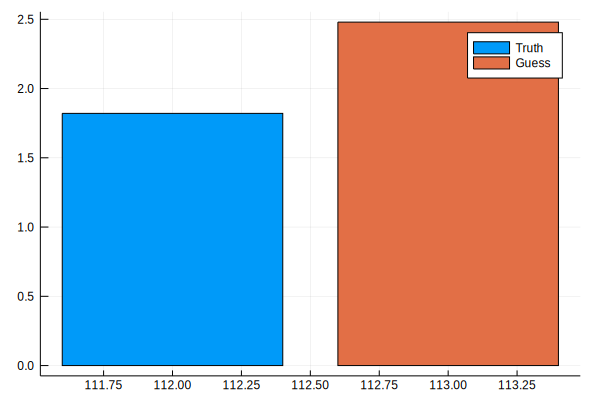

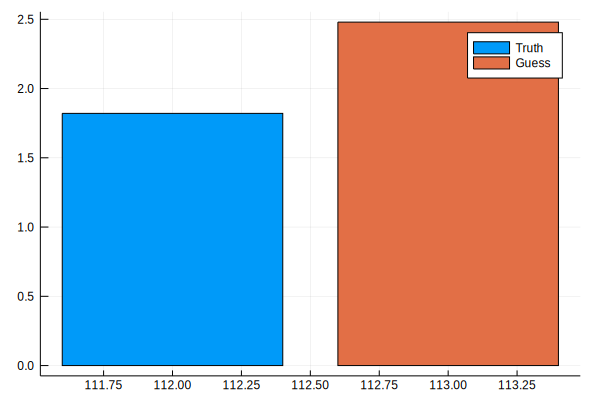

In [74]:
# Plots.bar([size(input_data,1)-1,size(input_data,1)], [truth, guess], label="Truth")

Plots.bar!([size(input_data,1)-1], [truth], label="Truth")
Plots.bar!([size(input_data,1)], [guess], label="Guess")

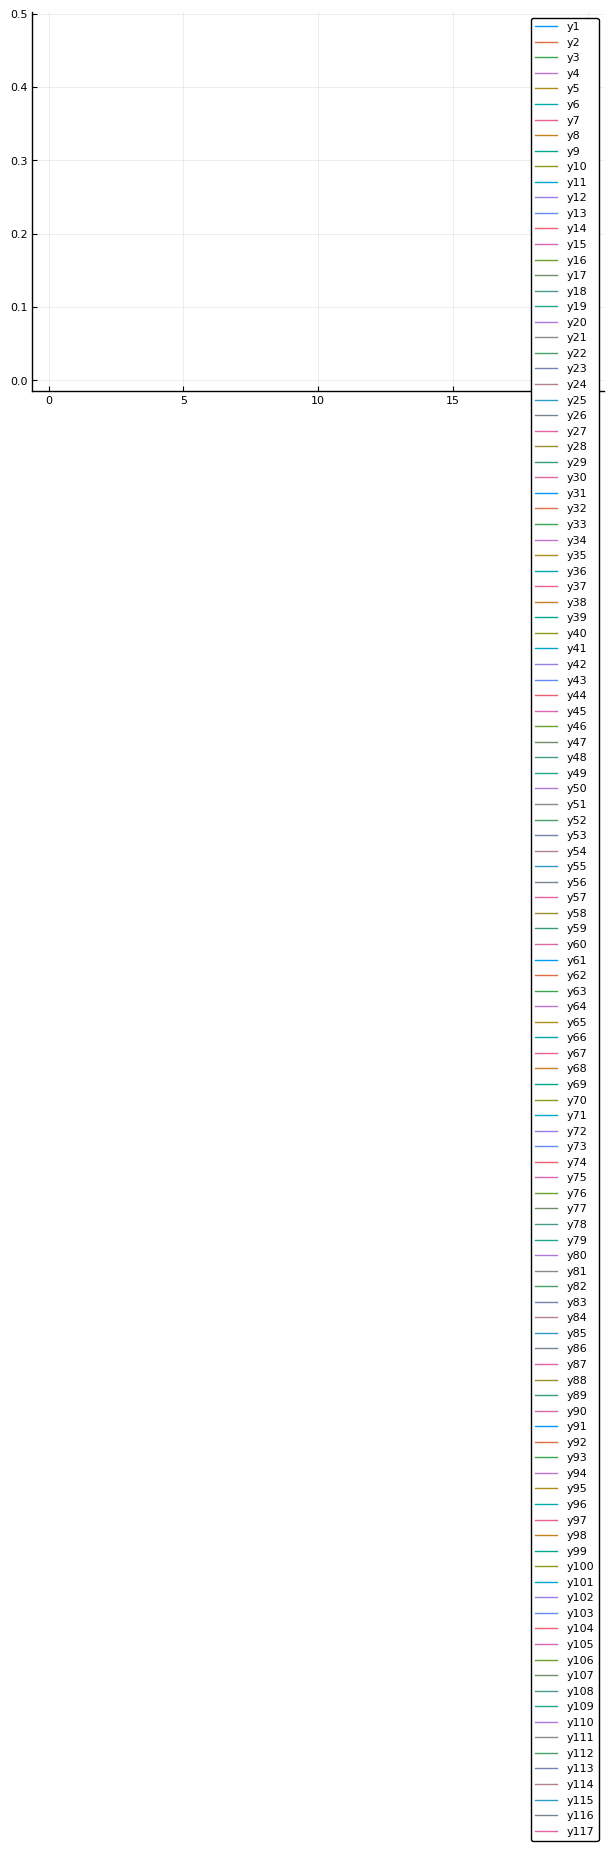

In [30]:
using Plots
pyplot() #change to the pyplot backend and define some defaults
# x = y = range(-5, stop = 5, length = 40)
# zs = zeros(0,40)
# n = 100

# create a progress bar for tracking the animation generation

sample_vec = shuffle(1:length(tst_data_stride))
i = sample_vec[1];
input_data = reshape(float.(tst_data_stride[i]), (size(tst_data_stride[i],1),size(tst_data_stride[i],2),1,1));
truth = max_forces_tst[i];
timevec = collect(0:10:size(input_data,1)*10);

anim = Animation()

p1 = Plots.plot(zeros(1,length(timevec)), zeros(1,length(timevec)))
for i in 1:3

    # create a plot with 3 subplots and a custom layout

    # induce a slight oscillating camera angle sweep, in degrees (azimuth, altitude)
    plot!(p1, [timevec[i]], [input_data[i,1]], show = true)

    # add a tracking line
#     fixed_x = zeros(40)
#     z = map(f, fixed_x, y)
#     plot!(p[1], fixed_x, y, z, line = (:black, 5, 0.2))
#     vline!(p[2], [0], line = (:black, 5))

    # add to and show the tracked values over time
#     global zs = vcat(zs, z')
#     plot!(p[3], zs, alpha = 0.2, palette = cgrad(:blues).colors)
#     frame(anim)
    # increment the progress bar
#     next!(prog)
end

In [375]:
# function plot_points(time_in, stride_in, plt)
#     @gif for i in 1:10
#         println(plt)
#         push!(plt, time_in[i], stride_in[i,1])
#         gui(); sleep(0.5)
#     end
# end
using Plots
gr()
# plt1 = plot(1, title = "Plot", marker = 2)
sample_vec = shuffle(1:length(tst_data_stride))
i = sample_vec[1];
# for i in sample_vec[1]
input_data = reshape(float.(tst_data_stride[i]), (size(tst_data_stride[i],1),size(tst_data_stride[i],2),1,1));
#     guess = m(input_data);
truth = max_forces_tst[i];
timevec = collect(0:10:size(input_data,1)*10);
p = plot(1,xlim=(minimum(timevec),maximum(timevec)), ylim=(minimum(input_data[:,1]),maximum(input_data[:,1])), title = "Plot")

@gif for k in 1:10
    append!(p, k, tst_data_stride[i][k,1])
#         plot!(timevec[k], tst_data_stride[i][k])
#     PlotlyJS.gui(); PlotlyJS.sleep(0.5);
#         PyPlot.bar(timevec[end], m(input_data).data, label = "Guess Force")
#         PyPlot.bar(timevec[end], truth, label = "True Force")
end every 10
#     bar!(size(input_data,1)*10, guess)
#     bar!(size(input_data,1)*10, truth)
# end

MethodError: MethodError: no method matching append!(::Plots.Plot{Plots.GRBackend}, ::Int64, ::Float64)
Closest candidates are:
  append!(::Any, ::Any, ::Any, !Matched::Any) at /Users/jenniferdawkins/.julia/packages/Parsers/s5mSF/src/tries.jl:53
  append!(::Plots.Plot, ::Integer, !Matched::AbstractArray{T,1} where T) at /Users/jenniferdawkins/.julia/packages/Plots/rmogG/src/utils.jl:948
  append!(::Plots.Plot, ::Integer, !Matched::AbstractArray{T,1} where T, !Matched::AbstractArray{T,1} where T) at /Users/jenniferdawkins/.julia/packages/Plots/rmogG/src/utils.jl:963
  ...

In [258]:
function customRecon(new_data, eigenvecs, k_keep)
    if length(size(new_data))==1
        new_data = reshape(new_data, (length(new_data),1));
    end
    recon = eigenvecs[:,k_keep]*(transpose(new_data))
    return transpose(recon)
end
    

customRecon (generic function with 1 method)

In [259]:
k = 5
recon_data = customRecon(buffer[k], vectors, k_keep);
recon_data_true = customRecon(tst_data_stride[s_order[k]], vectors, k_keep);

UndefVarError: UndefVarError: buffer not defined

In [260]:
k_keep

UndefVarError: UndefVarError: k_keep not defined

In [261]:
using Plots

In [262]:
plot(recon_data[:,1])
plot!(recon_data[:,2])
plot!(recon_data[:,3])
plot!(recon_data[:,4])
plot!(recon_data[:,5])
plot!(recon_data[:,6])

UndefVarError: UndefVarError: recon_data not defined

In [263]:
plot(recon_data_true[:,1])
plot!(recon_data_true[:,2])
plot!(recon_data_true[:,3])
plot!(recon_data_true[:,4])
plot!(recon_data_true[:,5])
plot!(recon_data_true[:,6])

UndefVarError: UndefVarError: recon_data_true not defined

In [264]:
plot(data0[1:1000,1])
plot!(data0[1:1000,2])
plot!(data0[1:1000,3])
plot!(data0[1:1000,4])
plot!(data0[1:1000,5])
plot!(data0[1:1000,6])